In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn
import scipy as sp

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy as sp
import scipy.interpolate as ip
import scipy.optimize as op
import scipy.signal as sg

import tqdm.auto as tqdm

np.random.seed(123)

In [2]:
exp_dir = f"../data/experimental_spectra/topspin/4096/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine", "mdma"]
exp_range = {"ampicillin": [1500, 2500],
             "aspala": [1500, 2500],
             "flutamide": [1500, 2500],
             "histidine": [1500, 2500],
             "thymol": [1500, 2500],
             "tyrosine": [1500, 2500],
             "mdma": [1600, 2400],
            }
align_regions = {"ampicillin": [12., 9.],
                 "aspala": [15., 11.],
                 "flutamide": [11., 9.],
                 "histidine": [18., 16.],
                 "thymol": [6.7, 5.7],
                 "tyrosine": [14., 11.],
                 "mdma": [4., 2.],
                }

align_ind = -1

fit_ranges = {"ampicillin": [[9.5, 12.]],
              "aspala": [[12., 15.], [-2., 1.5]],
              "flutamide": [[9.5, 12.]],
              "histidine": [[16., 20.], [11.5, 13.5], [4.5, 6.]],
              "thymol": [[8.5, 15.]],
              "tyrosine": [[12., 14.], [9.5, 11.5], [-2., 3.]],
              "mdma": [[1., 3.8]]}
bounds = [(None, None), (1.e-6, None), (0., 1.), (0., None)]
bounds_v = [(None, None), (1.e-6, None), (1.e-6, None), (0., None)]

ylabs_v = ["p", "wg", "wl", "h"]
ylabs_s = ["p", "w", "m", "h"]
ylabs_p = ["p", "w", "m", "h"]

w0s = np.linspace(0.1, 1, 10)
min_w_fit = 40000.

fig_dir = "../figures/GL_fitting_full_spectra/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

# Load experimental data

In [3]:
def inverse_mas_fit(wr, a, b):
    
    y = a + b / wr
    
    return y

In [4]:
def inverse_mas2_fit(wr, a, b, c):
    
    y = a + b / wr + c / (np.square(wr))
    
    return y

In [5]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"

    with open(fr, "rb") as F:
        dr = np.fromfile(F, np.int32).astype(float)

    with open(fi, "rb") as F:
        di = np.fromfile(F, np.int32).astype(float)

    with open(f"{d}acqus", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$MASR"):
            wr = int(l.split("=")[1].strip())
        if l.startswith("##$TD="):
            TD = int(l.split("=")[1].strip())
        if l.startswith("##$SW_h="):
            SW = float(l.split("=")[1].strip())

    with open(f"{pd}procs", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$SI="):
            n_pts = int(l.split("=")[1].strip())

        if l.startswith("##$OFFSET="):
            offset = float(l.split("=")[1].strip())

        if l.startswith("##$SF="):
            SF = float(l.split("=")[1].strip())
            
    AQ = TD / (2 * SW)

    hz = offset * SF - np.arange(n_pts) / (2 * AQ * n_pts / TD)
    
    ppm = hz / SF

    return dr, di, wr, ppm, hz

In [6]:
def extract_exp_topspin(in_dir, compound):
    
    d0 = f"{in_dir}{compound}/"
    
    ws = []
    X = []
    
    for d in os.listdir(d0):
        if d.isnumeric():
            Xi, _, wr, ppm, hz = load_topspin_spectrum(f"{d0}{d}/")
            X.append(Xi)
            ws.append(wr)
    
    sorted_inds = np.argsort(ws)
    
    sorted_ws = np.array([ws[i] for i in sorted_inds])
    
    sorted_X = np.array([X[i] for i in sorted_inds])
    
    return ppm, sorted_ws, sorted_X

In [7]:
def get_maximum(ppm, X, r, method="direct"):
    
    r0 = min(r)
    r1 = max(r)
    
    if method == "direct":
        
        inds = np.where(np.logical_and(ppm > r0, ppm < r1))[0]
        
        i0 = np.argmax(X[inds])
        w0 = ppm[inds[i0]]
        
    elif method == "interp":
        
        inds = np.where(np.logical_and(ppm > r0, ppm < r1))[0]
        f = ip.interp1d(range(len(inds)), X[inds], kind="cubic")
        
        x = np.linspace(0, len(inds)-1, 1001)
        x_ppm = ppm[inds[0]] + x * (ppm[inds[1]] - ppm[inds[0]])
        y = f(x)
        w0 = x_ppm[np.argmax(y)]
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return w0

In [8]:
def shift_spectrum(hz, Xr, Xi, dw):
    
    n = Xr.shape[0]
    t = np.arange(n) / np.abs(hz[1] - hz[0]) / n
    
    X = Xr + 1j * Xi
    
    T = np.fft.ifft(X)
    
    T *= np.exp(1j*dw*t * 2 * np.pi)
    X = np.fft.fft(T)
    Xr = np.real(X)
    Xi = np.imag(X)
    
    return Xr, Xi

In [9]:
def extract_and_shift_exp_topspin(in_dir, compound, align_region, align_ind=-1, method="interp"):
    
    d0 = f"{in_dir}{compound}/"
    
    ws = []
    X_real = []
    X_imag = []
    for d in os.listdir(d0):
        if d.isnumeric():
            Xr, Xi, wr, ppm, hz = load_topspin_spectrum(f"{d0}{d}/")
            X_real.append(Xr)
            X_imag.append(Xi)
            ws.append(wr)
    
    sorted_inds = np.argsort(ws)
    
    sorted_ws = np.array([ws[i] for i in sorted_inds])
    
    sorted_Xr = np.array([X_real[i] for i in sorted_inds])
    sorted_Xi = np.array([X_imag[i] for i in sorted_inds])
    
    # Extract target shift
    align_region_hz = [hz[np.argmin(np.abs(ppm - align_region[0]))], hz[np.argmin(np.abs(ppm - align_region[1]))]]
    w0 = get_maximum(hz, sorted_Xr[align_ind], align_region_hz, method=method)
    w0_ppm = get_maximum(ppm, sorted_Xr[align_ind], align_region, method=method)
    
    shifted_Xr = []
    shifted_Xi = []
    all_dw = []
    all_dw_ppm = []
    
    all_w = []
    for Xr, Xi in zip(sorted_Xr, sorted_Xi):
        # Get actual shift
        this_w = get_maximum(hz, Xr, align_region_hz, method=method)
        this_w_ppm = get_maximum(ppm, Xr, align_region, method=method)
        dw = this_w - w0
        all_dw.append(this_w- w0)
        all_dw_ppm.append(this_w_ppm- w0_ppm)
        
        # Shift spectrum
        Xr2, Xi2 = shift_spectrum(hz, Xr, Xi, dw)
        
        shifted_Xr.append(Xr2)
        shifted_Xi.append(Xi2)
    
    return ppm, sorted_ws, np.array(shifted_Xr), np.array(shifted_Xi), np.array(all_dw), np.array(all_dw_ppm), sorted_Xr, sorted_Xi

In [56]:
ppms = []
Xs = []
all_ws = []
for compound in exp_compounds:
    r = exp_range[compound]
    print(compound)
    ppm, ws, X, _, all_dw, all_dw_ppm, X0, _ = extract_and_shift_exp_topspin(exp_dir, compound, align_regions[compound], align_ind=align_ind)

    ppm = ppm[r[0]:r[1]]
    X = X0[:, r[0]:r[1]]

    X /= np.sum(X, axis=1)[:, np.newaxis]
    
    X = X[ws >= 40000]
    ws = ws[ws >= 40000]
    
    ppms.append(ppm)
    Xs.append(X)
    all_ws.append(ws)

ampicillin
aspala
flutamide
histidine
thymol
tyrosine
mdma


In [57]:
def voigt(x, p, wg, wl, h, eps=1e-12):
    
    G = np.exp(-4 * np.log(2) * np.square(x-p) / (wg ** 2))
    L = 1 / (1 + 4 * np.square(x-p) / (wl ** 2))
    
    print(np.max(G), np.max(L))
    
    V = sg.convolve(G, L, mode="same")
    
    print(np.max(V))
    
    if np.max(V) < eps:
        return V
    
    V /= np.max(V) / h
    
    return V

In [58]:
def gls(x, p, w, m, h):
    
    y = h * (1-m) * np.exp(-4 * np.log(2) * np.square(x-p) / (w ** 2))
    
    y += h * m / (1 + 4 * np.square(x-p) / (w ** 2))
    
    return y

In [59]:
def glp(x, p, w, m, h):
    
    y = h * np.exp(-4 * np.log(2) * (1-m) * np.square(x-p) / (w ** 2))
    
    y /= (1 + 4 * m * np.square(x-p) / (w ** 2))
    
    return y

In [60]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1 - y2)))

In [61]:
def to_minimize(x0, x, y, f):
    
    y2 = np.zeros_like(x)
    
    i = 0
    while i < len(x0):
        [p, w, m, h] = x0[i:i+4]
        y2 += f(x, p, w, m, h)
        i += 4
    
    return rmse(y, y2)

In [62]:
def to_minimize_fixed_peaks(x0, x, peaks, y, f):
    
    y2 = np.zeros_like(x)
    
    i = 0
    for p in peaks:
        [w, m, h] = x0[i:i+3]
        y2 += f(x, p, w, m, h)
        i += 3
    
    return rmse(y, y2)

In [63]:
x = np.linspace(-10., 10., 10001)

In [64]:
peak_pos_guess = {"ampicillin": [10., 7.5, 7.1, 6.8, 6.5, 5.5, 5.1, 4.6, 3.9, 1.6, 0.9],
                 }

In [133]:
r0 = 20.
r1 = 5.
c0 = np.array([0., 1., 1.])
dc = np.array([0., -1., 0.])

for compound, ppm, X, ws in zip(exp_compounds, ppms, Xs, all_ws):
    print(compound)

    fdir = f"{fig_dir}{compound}/"
    if not os.path.exists(fdir):
        os.mkdir(fdir)

    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    for i, Xi in enumerate(X):
        ax.plot(ppm, Xi, color=c0 + i/(X.shape[0]-1) * dc, linewidth=1.)

    ax.set_xlim(r0, r1)
    ax.set_xlabel("Chemical shift [ppm]")
    ax.set_yticks([])
    fig.tight_layout()
    plt.savefig(f"{fdir}spectra.pdf")
    #plt.show()
    plt.close()

    fit_v = []
    fit_s = []
    fit_p = []

    fit_rmses_v = []
    fit_rmses_s = []
    fit_rmses_p = []

    inds = np.where(np.logical_and(ppm > r0, ppm < r1))
    
    all_res = []

    for i, (wi, Xi) in tqdm.tqdm(enumerate(zip(ws, X)), total=len(ws)):
        
        # Set bounds
        bounds = []
        x0 = []
        for p in peak_pos_guess[compound]:
            bounds.append((1e-6, None))
            bounds.append((0., 1.))
            bounds.append((0., np.max(Xi)))
            
            x0.append(1.)
            x0.append(0.5)
            x0.append(Xi[np.argmin(np.abs(ppm - p))])
        
        res = op.minimize(to_minimize_fixed_peaks, x0, args=(ppm, peak_pos_guess[compound], Xi, gls),
                          bounds=bounds, method="Nelder-Mead", options={"adaptive": True, "maxiter": 1e3})
        
        bounds = []
        x0 = []
        i = 0
        for p in peak_pos_guess[compound]:
            x0.append(p)
            bounds.append((p - 0.5, p + 0.5))
            [w, m, h] = res.x[i:i+3]
            x0.append(w)
            bounds.append((0., 2 * w))
            x0.append(m)
            bounds.append((0., 1.))
            x0.append(h)
            bounds.append((0., np.max(Xi)))
            i += 3
        
        res = op.minimize(to_minimize, x0, args=(ppm, Xi, gls), bounds=bounds,
                          method="Nelder-Mead", options={"adaptive": True, "maxiter": 1e4})
        
        all_res.append(res.x)
        
    all_res = np.array(all_res)
    
    break

ampicillin


  0%|          | 0/31 [00:00<?, ?it/s]

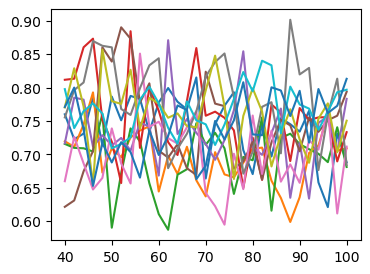

In [132]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
i = 2
while i < all_res.shape[1]:
    
    ax.plot(ws / 1000., all_res[:, i])
    i += 4

plt.show()
plt.close()

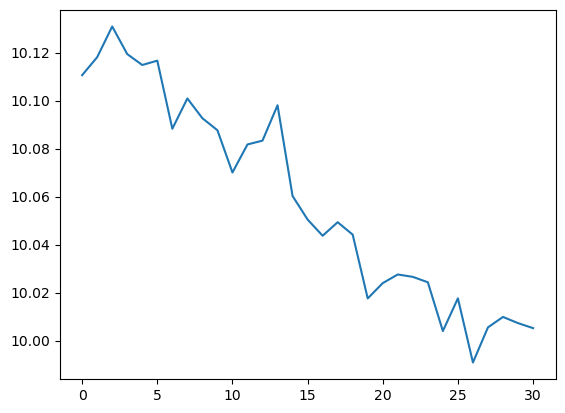

In [118]:
plt.plot(all_res[:, 0])
plt.show()
plt.close()

In [109]:
y = np.zeros_like(ppm)
i = 0
while i < len(res.x):
    [p, w, m, h] = res.x[i:i+4]
    y += gls(ppm, p, w, m, h)
    i += 4

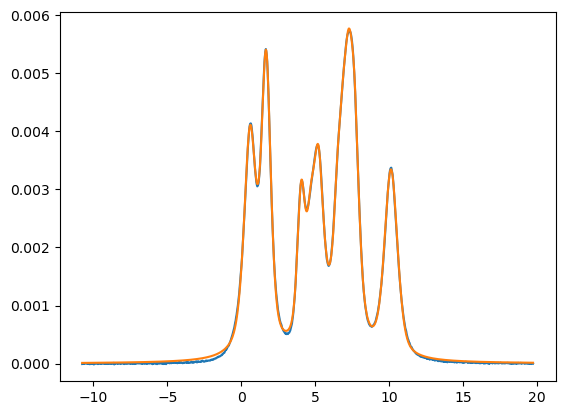

In [110]:
plt.plot(ppm, Xi)
plt.plot(ppm, y)
plt.show()
plt.close()